# Imbalance, Stacking, Timing, and Multicore

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform

import time
import os

## Imbalance: see weights used by svm.SVC()'s class_weight='balanced'

In [5]:
y = np.array([0, 0, 0, 0, 0, 1]) # 5 zeros, 1 one
N = y.shape # 6
counts = np.bincount(y) # array([5, 1])
n_classes = counts.shape # 2
C_1, C_2 = N / (n_classes * counts) # 0.6, 3
print(f'counts={counts}, C_1={C_1}, C_2={C_2}')

counts=[5 1], C_1=0.6, C_2=3.0


## Imbalance: oversampling, undersampling

In [8]:
# Do 'New > Terminal' and then run 'conda install -c conda-forge imbalanced-learn' to install package.
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X = np.array([1, 2, 3, 4, 5, 6]).reshape(-1, 1)
y = np.array([0, 0, 0, 0, 1, 1])
rs = RandomOverSampler()
X_resampled, y_resampled = rs.fit_resample(X, y)
print(f'Oversampling: X_resampled={X_resampled},\ny_resampled={y_resampled}')
rs = RandomUnderSampler()
X_resampled, y_resampled = rs.fit_resample(X, y)
print(f'Undersampling: X_resampled={X_resampled},\ny_resampled={y_resampled}')

Oversampling: X_resampled=[[1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [5]
 [6]],
y_resampled=[0 0 0 0 1 1 1 1]
Undersampling: X_resampled=[[3]
 [2]
 [5]
 [6]],
y_resampled=[0 0 1 1]


## Stacking

In [11]:
digits = load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

### First check classifiers individually.

In [13]:
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.98

In [15]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8066666666666666

In [17]:
clf = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9822222222222222

In [18]:
clf = LogisticRegression(max_iter=3000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.96

### Try stacking the first three, using the fourth as the final estimator.

In [21]:
estimators = [
    ('SVM', svm.SVC(kernel="linear", C=1000)),
    ('kNN', KNeighborsClassifier(n_neighbors=1, metric='euclidean')),
    ('DecisionTree', DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=3000)
)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9888888888888889

### See if we can understand what the StackingClassifier() did.

In [23]:
# inspect components of clf:
print(f'clf.estimators_={clf.estimators_}')
print(f'clf.final_estimator_={clf.final_estimator_}')
print(f'clf.stack_method_={clf.stack_method_}')

clf.estimators_=[SVC(C=1000, kernel='linear'), KNeighborsClassifier(metric='euclidean', n_neighbors=1), DecisionTreeClassifier(criterion='entropy', random_state=0)]
clf.final_estimator_=LogisticRegression(max_iter=3000)
clf.stack_method_=['decision_function', 'predict_proba', 'predict_proba']


In [25]:
# reproduce the StackingClassifier()'s output without using StackingClassifier(),
# directly from the stacking description in the lecture notes:
np.set_printoptions(precision=3)

y1_hat = clf.estimators_[0].decision_function(X_test)
print(f'y1_hat{y1_hat.shape}={y1_hat}')

y2_hat = clf.estimators_[1].predict_proba(X_test)
print(f'y2_hat{y2_hat.shape}={y2_hat}')

y3_hat = clf.estimators_[2].predict_proba(X_test)
print(f'y3_hat{y3_hat.shape}={y3_hat}')

x_hat = np.column_stack((y1_hat, y2_hat, y3_hat))
print(f'x_hat{x_hat.shape}={x_hat}')
y_hat = clf.final_estimator_.predict(x_hat)
print(f'y_hat{y_hat.shape}={y_hat}')

y_hat_from_clf = clf.predict(X_test)
print(f'y_hat_from_clf{y_hat_from_clf.shape}={y_hat_from_clf}')

assert np.all(y_hat == y_hat_from_clf)

y1_hat(450, 10)=[[ 6.289  1.732  9.307 ...  3.821  4.77   6.239]
 [ 9.312  1.697  2.735 ...  0.703  6.308  5.17 ]
 [ 3.787  5.252 -0.31  ...  7.276  6.306  3.767]
 ...
 [-0.316  9.314  7.279 ...  4.764  7.305  2.711]
 [ 2.785  9.288  0.733 ...  1.715  7.311  4.926]
 [ 1.729  8.295 -0.319 ...  6.264  5.283  9.32 ]]
y2_hat(450, 10)=[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
y3_hat(450, 10)=[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
x_hat(450, 30)=[[ 6.289  1.732  9.307 ...  0.     0.     0.   ]
 [ 9.312  1.697  2.735 ...  0.     0.     0.   ]
 [ 3.787  5.252 -0.31  ...  0.     0.     0.   ]
 ...
 [-0.316  9.314  7.279 ...  0.     0.     0.   ]
 [ 2.785  9.288  0.733 ...  0.     0.     0.   ]
 [ 1.729  8.295 -0.319 ...  0.     0.     1.   ]]
y_hat(450,)=[2 0 4 9 4 1 

## Algorithm Efficiency and Timing Code
If you do not know the run-time of your algorithm, you can time it for several values
to get some insight as to how the time relates to the input size.

e.g. Here we time sorting arrays of random numbers for each of several sample sizes
and the make a plot to see the relationship between run time and sample size.

In [27]:
sample_sizes = 1000000 * (1 + np.arange(10))
n_sizes = len(sample_sizes)
times = np.zeros(shape=n_sizes)
rng = np.random.default_rng(seed=0)
for i in np.arange(n_sizes):
    N = sample_sizes[i]
    a = np.random.sample(size=N) # random floats from [0.0, 1.0)
    start = time.time()
    discard = np.sort(a) # how fast is this algorithm?"
    end = time.time()
    times[i] = end - start
    print(f'i={i}, N={N}, times[i]={times[i]}')

i=0, N=1000000, times[i]=0.22222638130187988
i=1, N=2000000, times[i]=0.46044015884399414
i=2, N=3000000, times[i]=0.7324714660644531
i=3, N=4000000, times[i]=0.9209256172180176
i=4, N=5000000, times[i]=1.201984167098999
i=5, N=6000000, times[i]=1.4268043041229248
i=6, N=7000000, times[i]=1.6936249732971191
i=7, N=8000000, times[i]=2.012718915939331
i=8, N=9000000, times[i]=2.1742234230041504
i=9, N=10000000, times[i]=2.477682113647461


Text(0, 0.5, 'time (seconds)')

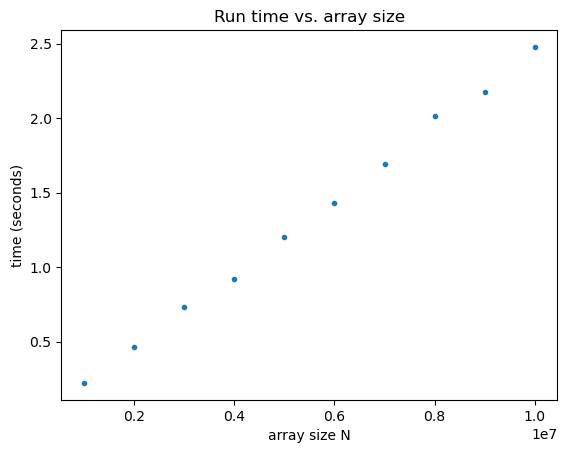

In [28]:
plt.plot(sample_sizes, times, '.')
plt.title('Run time vs. array size')
plt.xlabel('array size N')
plt.ylabel('time (seconds)')

It would be easy to make a regression model, or just estimate the model by eye,
and then predict the run time for a particular N. (I am recommending extrapolating
here as better than nothing, even though extrapolation is typically risky.)

### Multicore computing

In [ ]:
n_CPU = os.cpu_count()
print(f'n_CPU={n_CPU}.')

df = pd.read_csv('http://www.stat.wisc.edu/~jgillett/451/data/circles.csv')
X = df[['x0', 'x1']]
y = df['y']

rng = np.random.default_rng(seed=0)
distributions = {
    'kernel': ('linear', 'rbf'),
    'C': uniform(loc=0, scale=1000) # uniform[loc, loc + scale]
}

times = np.zeros(shape=n_CPU+1) # ignore position [0]
numbers_of_CPUs = 1 + np.arange(start=0, stop=n_CPU)
for n_jobs in numbers_of_CPUs:
  clf = RandomizedSearchCV(svm.SVC(), param_distributions=distributions, n_iter=100, n_jobs=n_jobs)
  start = time.time()
  clf.fit(X, y)
  end = time.time()
  print(f'clf.best_score_={clf.best_score_:.3}, ' + f'clf.best_params_={clf.best_params_}')
  times[n_jobs] = end - start
  print(f'n_jobs={n_jobs}, clf.fit() took {times[n_jobs]:.3} seconds.')

plt.plot(numbers_of_CPUs, times[1:], 'or')
plt.title('RandomizedSearchCV() time vs. n_jobs')
plt.xticks(ticks=np.append(0, numbers_of_CPUs))
plt.xlabel('n_jobs')
plt.ylabel('time (seconds)')
_ = plt.ylim(0, 1.1*np.max(times))
